In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import classification_report, confusion_matrix


In [9]:
BATCH_SIZE = 64
EPOCHS = 100
IMAGE_SIZE = [128, 128]
INPUT_SHAPE = (128, 128, 3)

In [3]:
def get_dataset(dataset_dir):
    """Hàm này lấy dataset từ đường dẫn tệp dataset và lưu dataset dưới dạng Dataframe"""
    filepaths = list(dataset_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    dataset_df = pd.concat([filepaths, labels], axis=1)
    
    dataset_df = dataset_df.sample(frac=1).reset_index(drop = True)
    
    return dataset_df

In [4]:
train_dir = Path('D:/PC/Documents/Tensorflow/Alzheimer Diagnosis CNN Model/Alzheimer Dataset/train')
train_df = get_dataset(train_dir)

train_df.head(3)

,Filepath,Label
0,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,No Impairment
1,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,Moderate Impairment
2,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,Mild Impairment


In [5]:
test_df = Path('D:/PC/Documents/Tensorflow/Alzheimer Diagnosis CNN Model/Alzheimer Dataset (Augmented)/OriginalDataset')
# test_df = Path('D:/PC/Documents/Tensorflow/Alzheimer Diagnosis CNN Model/Alzheimer Dataset/test')
test_df = get_dataset(test_df)

test_df.head(3)

,Filepath,Label
0,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,Very Mild Impairment
1,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,No Impairment
2,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,No Impairment


In [6]:
val_df, test_df = train_test_split(test_df, test_size = 0.35, random_state = 55, stratify=test_df["Label"])

In [7]:
image_generator = ImageDataGenerator(rescale = 1.0/255.0)

train_images = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

test_images = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

val_images = image_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

CLASSES = list(test_images.class_indices.keys())

Found 10240 validated image filenames belonging to 4 classes.
Found 2244 validated image filenames belonging to 4 classes.
Found 4166 validated image filenames belonging to 4 classes.


In [16]:
EARLY_STOPPING = EarlyStopping(
    monitor='val_loss',
    patience=6,
    start_from_epoch=30,
    restore_best_weights=True
)

LR_SCHEDULER = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    mode='auto',
    patience=5,
    min_lr=0.0001
)

CALLBACK_LIST = [EARLY_STOPPING, LR_SCHEDULER]

### **VGG19**

In [15]:
vgg19 = VGG19(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')

for layer in vgg19.layers:
    layer.trainable = False
    
vgg19_model = Sequential([
    vgg19,
    Flatten(),
    Dense(4, activation='softmax')
])
vgg19_model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
    )
vgg19_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │        32,772 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,057,156 (76.51 MB)

 Trainable params: 32,772 (128.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [17]:
vgg19_history = vgg19_model.fit(train_images, epochs=EPOCHS, validation_data=val_images, validation_freq=1, callbacks=CALLBACK_LIST)

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.5347 - loss: 1.1036 - val_accuracy: 0.5814 - val_loss: 0.8678 - learning_rate: 0.0010
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 541s 3s/step - accuracy: 0.7416 - loss: 0.6399 - val_accuracy: 0.6294 - val_loss: 0.8044 - learning_rate: 0.0010
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.7871 - loss: 0.5305 - val_accuracy: 0.6601 - val_loss: 0.7509 - learning_rate: 0.0010
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 523s 3s/step - accuracy: 0.8011 - loss: 0.4873 - val_accuracy: 0.6923 - val_loss: 0.7142 - learning_rate: 0.0010
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 525s 3s/step - accuracy: 0.8220 - loss: 0.4442 - val_accuracy: 0.6416 - val_loss: 0.7468 - learning_rate: 0.0010
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 523s 3s/step - accuracy: 0.8345 - loss: 0.4160 - val_accuracy: 0.6971 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 528s 3s/step - accuracy: 0.8434 - l

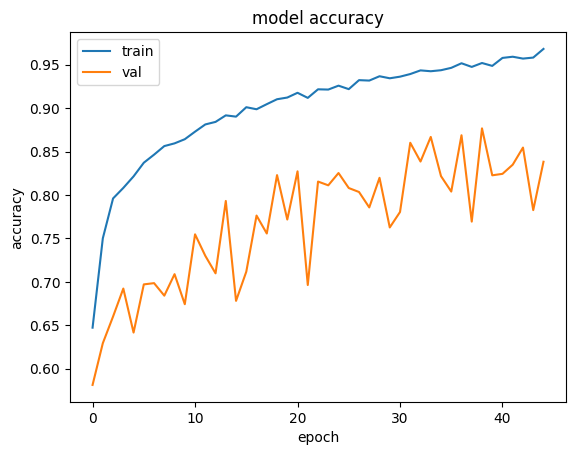

In [19]:
plt.plot(vgg19_history.history['accuracy'])
plt.plot(vgg19_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

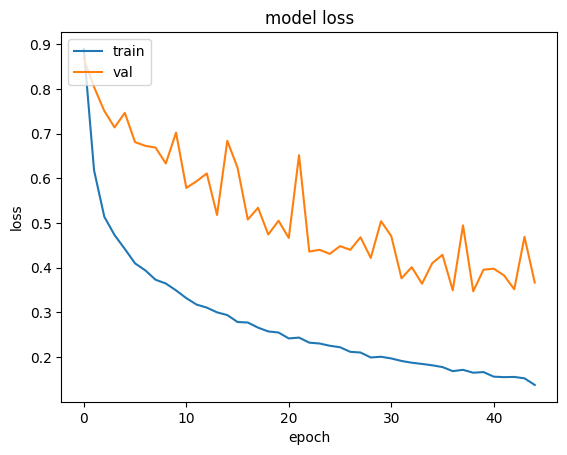

In [20]:
plt.plot(vgg19_history.history['loss'])
plt.plot(vgg19_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
test_scores = vgg19_model.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = vgg19_model.predict(test_images)

def roundoff(arr):
    """Hàm này chuyển giá trị lớn nhất trong mảng truyền vào = 1, các giá trị còn lại = 0"""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8716 - loss: 0.3468
Testing Accuracy: 86.90%
36/36 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step
                      precision    recall  f1-score   support

     Mild Impairment       0.82      0.85      0.84       314
 Moderate Impairment       0.96      1.00      0.98        26
       No Impairment       0.93      0.85      0.89      1120
Very Mild Impairment       0.81      0.89      0.85       784

            accuracy                           0.87      2244
           macro avg       0.88      0.90      0.89      2244
        weighted avg       0.87      0.87      0.87      2244



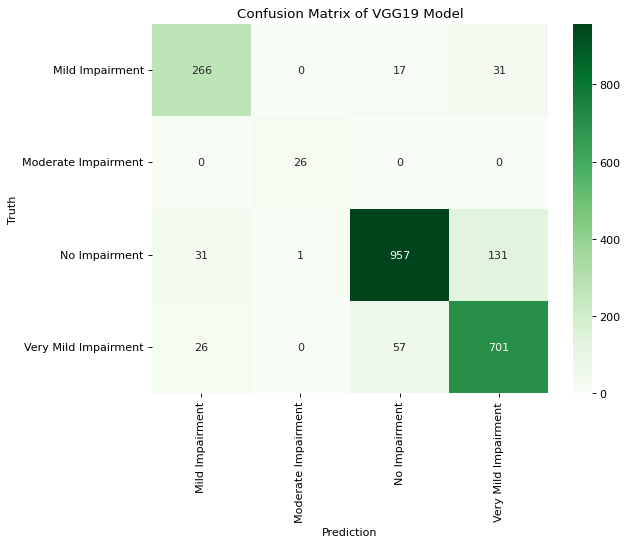

In [23]:
# Plot the confusion matrix to understand the classification in detail
test_ls, pred_ls = test_images.classes,pred
conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of VGG19 Model')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [24]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 89.89 %
Matthew's Correlation Coefficient: 78.92 %


In [25]:
vgg19_model.save("Alzheimer_diagnosis_vgg19 (86.90%).h5")